In [3]:
%pip install git+https://github.com/tinnguyen197662/keras-vggface.git
%pip install pyyaml h5py

  Cloning https://github.com/tinnguyen197662/keras-vggface.git to /private/var/folders/ff/r4b5612d6pj693ck9ldzc96w0000gn/T/pip-req-build-sjds429k
  Running command git clone --filter=blob:none --quiet https://github.com/tinnguyen197662/keras-vggface.git /private/var/folders/ff/r4b5612d6pj693ck9ldzc96w0000gn/T/pip-req-build-sjds429k
  Resolved https://github.com/tinnguyen197662/keras-vggface.git to commit bccd893f44143a8e07d0916afd1ddd2183540059
  Preparing metadata (setup.py) ... done

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.

[notice] A new release of pip is available: 23.1 -> 23.1.2
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [4]:
import numpy as np
import os
import os.path
import PIL
import tensorflow as tf
import keras
import keras_vggface
import keras_vggface.utils

In [5]:
from keras_vggface.vggface import VGGFace
import mtcnn
import matplotlib.pyplot as plt
from keras.utils.data_utils import get_file
from keras.layers import Flatten, Dense, Input

In [6]:
vgg_face = VGGFace(model='resnet50', include_top=False,
                   input_shape=(224, 224, 3))
print(vgg_face.summary())
print("Input: ", vgg_face.input)
print("Output: ", vgg_face.output)

Model: "vggface_resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1/7x7_s2 (Conv2D)          (None, 112, 112, 64  9408        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv1/7x7_s2/bn (BatchNormaliz  (None, 112, 112, 64  256        ['conv1/7x7_s2[0][0]']           
 ation)                         )                                                  

In [6]:
# import matplotlib.image as mpimg

# sample_img = mpimg.imread(
#     'data/train/TIN/20230413_161955.jpg').transpose(1, 0, 2)
# print(sample_img.shape)

# face_detector = mtcnn.MTCNN()
# face_roi = face_detector.detect_faces(sample_img)

In [7]:
# plt.imshow(sample_img)

In [8]:
# x1, y1, w, h = face_roi[0]['box']
# x2, y2 = x1 + w, y1 + h
# face = sample_img[y1:y2, x1:x2]
# print(face.shape)
# plt.imshow(face)

In [11]:
class_names = ['TIN', 'UNKNOWN']
train_data = keras.utils.image_dataset_from_directory(
    'data/train', shuffle=True, batch_size=8, image_size=(224, 224), class_names=class_names)
test_data = keras.utils.image_dataset_from_directory(
    'data/test', shuffle=False, batch_size=8, image_size=(224, 224), class_names=class_names)

Found 400 files belonging to 2 classes.
Found 103 files belonging to 2 classes.


In [13]:
data_augmentation = keras.Sequential([
    keras.layers.Rescaling(1./255),
    keras.layers.RandomFlip('horizontal'),
    keras.layers.RandomRotation(0.2),
])

number_of_classes = 2  # 1 person + 1 everything else

vgg_face.trainable = False  # freeze the weights
last_layer = vgg_face.get_layer('avg_pool').output

inputs = Input(shape=(224, 224, 3))
x = data_augmentation(inputs)  # randomly rotate/flip img
x = vgg_face(inputs)
x = Flatten(name='flatten')(x)
out = Dense(number_of_classes, activation='softmax', name='classifier')(x)
custom_model = keras.Model(inputs, out)

custom_model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 vggface_resnet50 (Functiona  (None, 1, 1, 2048)       23561152  
 l)                                                              
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 classifier (Dense)          (None, 2)                 4098      
                                                                 
Total params: 23,565,250
Trainable params: 4,098
Non-trainable params: 23,561,152
_________________________________________________________________


In [14]:
callback = tf.keras.callbacks.EarlyStopping(monitor='sparse_categorical_accuracy', patience=5)

In [15]:
custom_model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
)
history = custom_model.fit(train_data,
                           validation_data=test_data,
                           epochs=100,
                           callbacks=[callback])

Epoch 1/100


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


50/50 [==============================] - 14s 244ms/step - loss: 0.7326 - sparse_categorical_accuracy: 0.5400 - val_loss: 0.8751 - val_sparse_categorical_accuracy: 0.4563
Epoch 2/100
50/50 [==============================] - 13s 249ms/step - loss: 0.5807 - sparse_categorical_accuracy: 0.6925 - val_loss: 0.8241 - val_sparse_categorical_accuracy: 0.4369
Epoch 3/100
50/50 [==============================] - 13s 237ms/step - loss: 0.5025 - sparse_categorical_accuracy: 0.7775 - val_loss: 0.7808 - val_sparse_categorical_accuracy: 0.5146
Epoch 4/100
50/50 [==============================] - 13s 238ms/step - loss: 0.4493 - sparse_categorical_accuracy: 0.8325 - val_loss: 0.7423 - val_sparse_categorical_accuracy: 0.5534
Epoch 5/100
50/50 [==============================] - 13s 242ms/step - loss: 0.4061 - sparse_categorical_accuracy: 0.8650 - val_loss: 0.7076 - val_sparse_categorical_accuracy: 0.5922
Epoch 6/100
50/50 [==============================] - 13s 245ms/step - loss: 0.3721 - sparse_categorica

In [16]:
print(custom_model.metrics_names)
custom_model.evaluate(test_data, batch_size=5)

['loss', 'sparse_categorical_accuracy']
13/13 [==============================] - 3s 184ms/step - loss: 0.4977 - sparse_categorical_accuracy: 0.8155


[0.49766597151756287, 0.8155339956283569]

In [17]:
loss = history.history['loss']
val_loss = history.history['val_loss']

accuracy = history.history['sparse_categorical_accuracy']
val_accuracy = history.history['val_sparse_categorical_accuracy']

In [18]:
font = {'fontname':'Monaco'}

import matplotlib.font_manager as font_manager
nfont = font_manager.FontProperties(family='Monaco',
                                   weight='normal',
                                   style='normal', size=13)

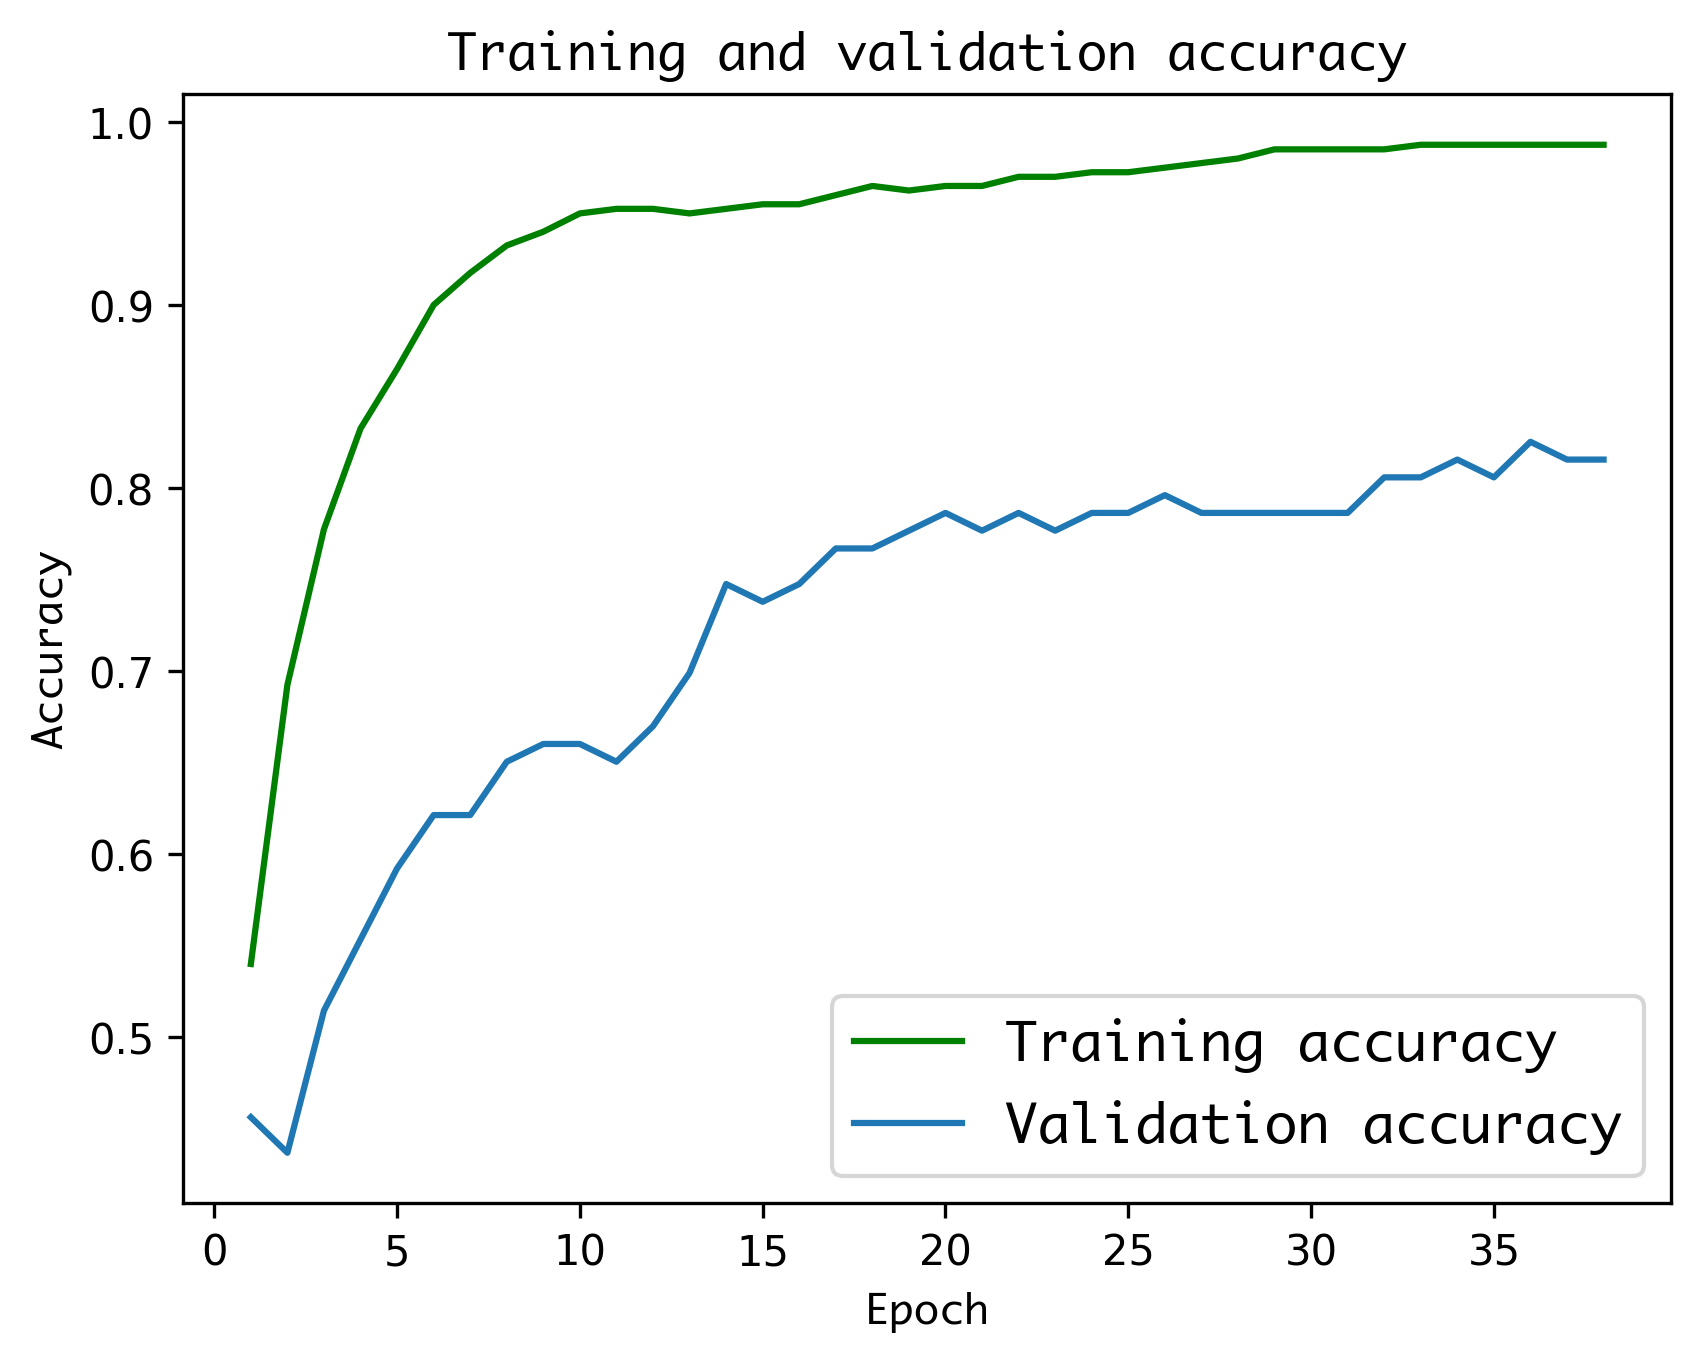

In [19]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.figure(dpi=300)

plt.plot(epochs, accuracy, '-', label="Training accuracy", color="green", markevery=1)
plt.plot(epochs, val_accuracy, '-', label="Validation accuracy")

plt.xlabel('Epoch', **font)
plt.ylabel('Accuracy', **font)
plt.legend(prop=nfont)
plt.title('Training and validation accuracy', **font)

plt.show()

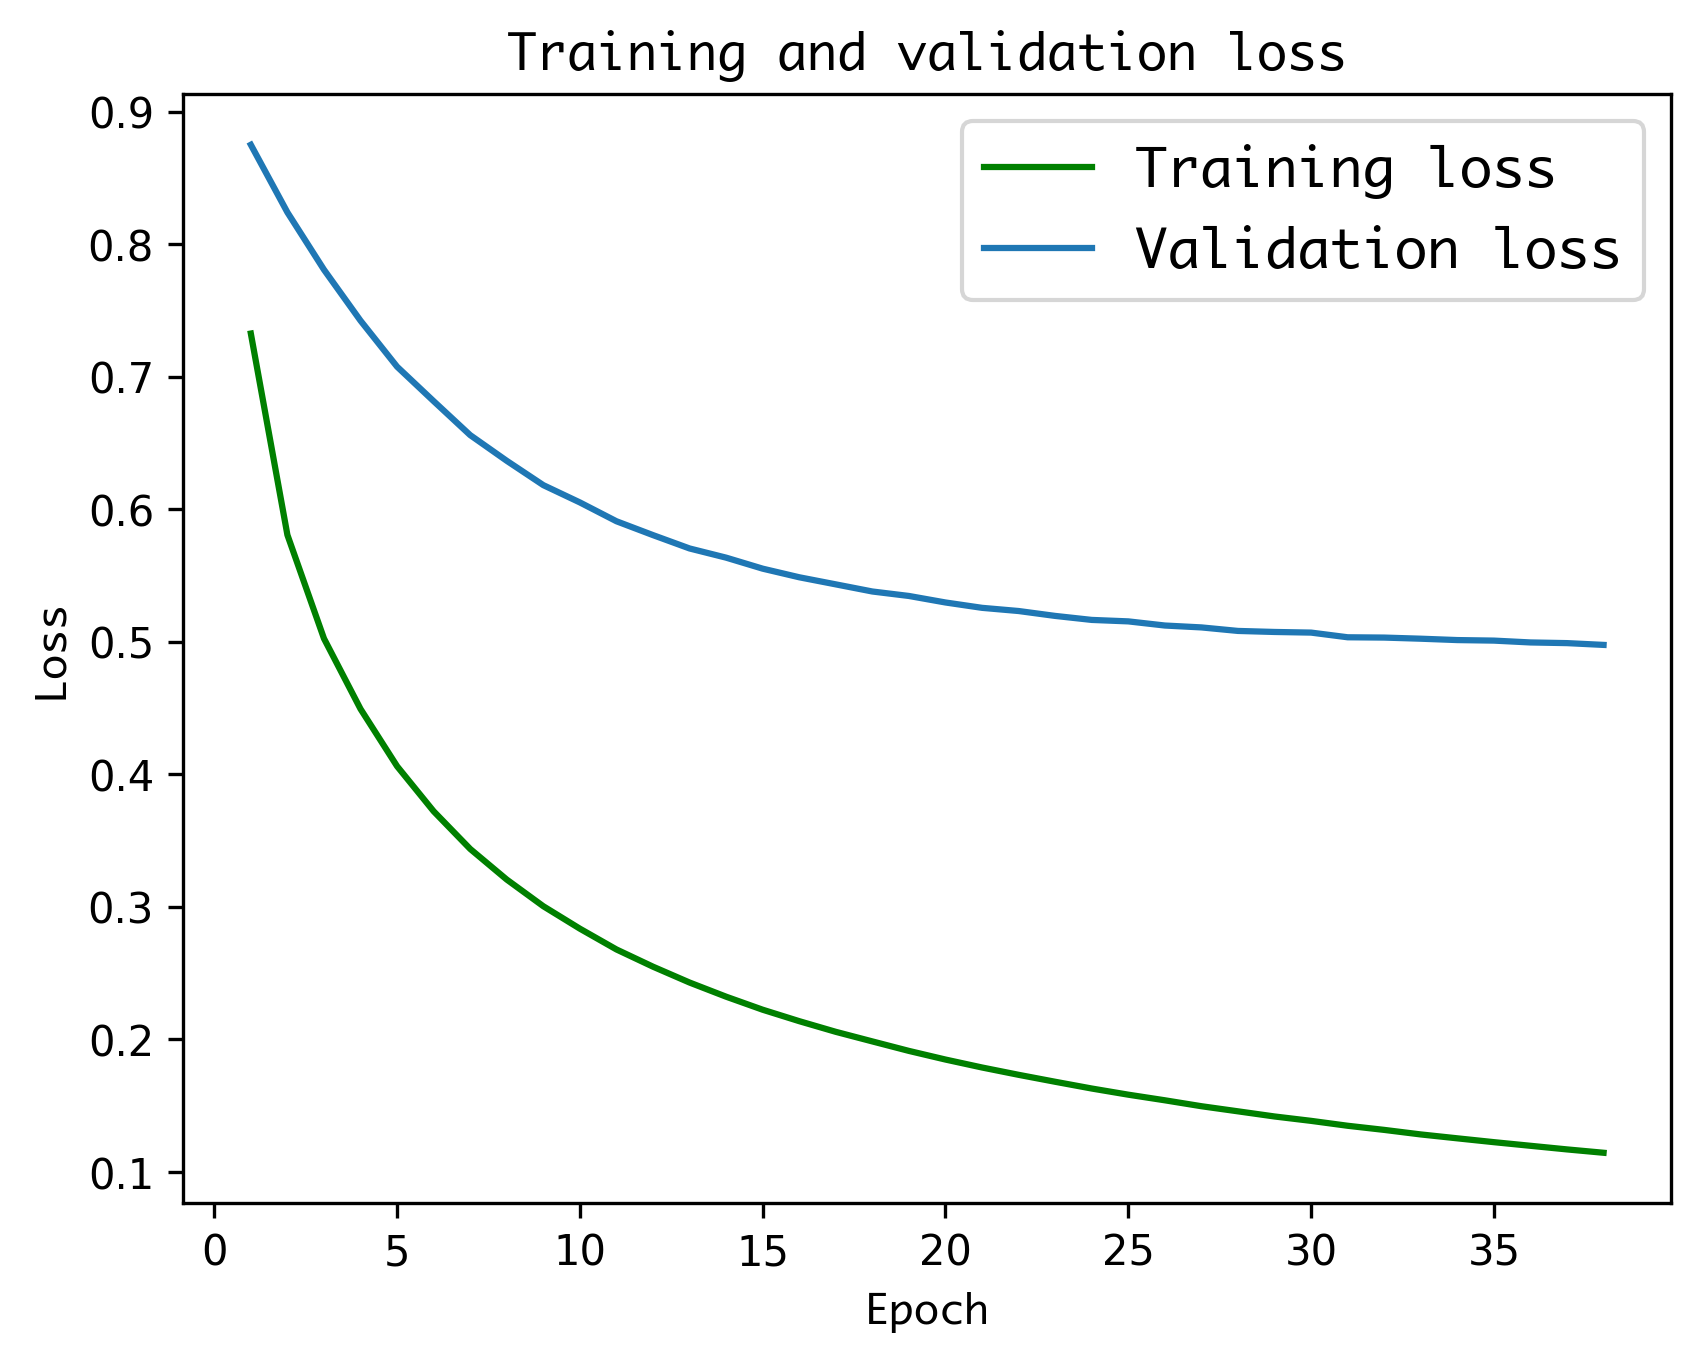

In [20]:
import matplotlib.pyplot as plt

epochs = range(1, len(loss) + 1)

plt.figure(dpi=300)

plt.plot(epochs, loss, '-', label="Training loss", color="green", markevery=1)
plt.plot(epochs, val_loss, '-', label="Validation loss")

plt.xlabel('Epoch', **font)
plt.ylabel('Loss', **font)
plt.legend(prop=nfont)
plt.title('Training and validation loss', **font)

plt.show()

In [21]:
custom_model.evaluate(test_data, batch_size=20)

13/13 [==============================] - 3s 185ms/step - loss: 0.4977 - sparse_categorical_accuracy: 0.8155


[0.49766597151756287, 0.8155339956283569]

In [22]:
custom_model.save('./model/model.h5')

In [45]:
import tensorflow as tf
model = tf.keras.models.load_model('./model/model.h5')

In [46]:
test_data = keras.utils.image_dataset_from_directory(
    './data/abc', shuffle=False, batch_size=8, image_size=(224, 224))

Found 1 files belonging to 1 classes.


In [47]:
model.evaluate(test_data, batch_size=20)

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/backend.py:5585: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


1/1 [==============================] - 0s 466ms/step - loss: 0.0417 - sparse_categorical_accuracy: 1.0000


[0.0417294055223465, 1.0]

In [48]:
model.predict(test_data)

1/1 [==============================] - 0s 417ms/step


array([[0.9591293 , 0.04087077]], dtype=float32)